In [2]:
!nvidia-smi

Wed Dec 27 11:58:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           Off| 00000000:01:00.0 Off |                    0 |
| N/A   39C    P0               69W / 300W|      0MiB / 81920MiB |     20%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import os

import numpy as np
from custom_stable_video_diffusion_pipeline import CustomStableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
from diffusers.utils.torch_utils import randn_tensor
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.spatial.transform import Rotation as R
from co3d.dataset.data_types import load_dataclass_jgzip, FrameAnnotation
from typing import List
from co3d.dataset.data_types import (
    load_dataclass_jgzip, FrameAnnotation, SequenceAnnotation
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from PIL import Image
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import SGDRegressor

from numpy.linalg import norm
import itertools

device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")


/work/ececis_research/peace/sw/anaconda-envs/svd3d/20231214/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:

def calculate_stats(data, label):
    data_norm = norm(data)
    data_mean = np.mean(data, axis=0)
    data_median = np.median(data, axis=0)
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)

    print(f"Stats for {label}:")
    print(f"Norm: {data_norm}")
    print(f"Mean: {data_mean}")
    print(f"Median: {data_median}")
    print(f"Min: {data_min}")
    print(f"Max: {data_max}\n")
    
def plot_3d_subset(y_true, y_pred, start_index=0, subset_size=25):
    """
    Plots a 3D comparison of true values and predictions for a specified subset.

    :param y_true: Array of true values.
    :param y_pred: Array of predicted values.
    :param start_index: Starting index for the subset to plot.
    :param subset_size: Number of data points in the subset to plot.
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Selecting the subset
    end_index = start_index + subset_size
    y_true_subset = y_true[start_index:end_index]
    y_pred_subset = y_pred[start_index:end_index]

    calculate_stats(y_true_subset, "Ground Truth")
    calculate_stats(y_pred_subset, "Predictions")


    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the ground truth for the subset
    ax.plot(y_true_subset[:, 0], y_true_subset[:, 1], y_true_subset[:, 2], color='red', label='Ground Truth', linestyle='-')

    # Plotting the predictions for the subset
    ax.plot(y_pred_subset[:, 0], y_pred_subset[:, 1], y_pred_subset[:, 2], color='orange', label='Predictions', linestyle='dashed')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()
    plt.title(f"3D Plot from index {start_index} to {end_index}")
    plt.show()



def plot_3d_subset_scaled(y_true, y_pred, start_index=0, subset_size=25):
    from sklearn.preprocessing import MinMaxScaler
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Selecting the subset
    end_index = start_index + subset_size
    y_true_subset = y_true[start_index:end_index]
    y_pred_subset = y_pred[start_index:end_index]

    # Min-Max scaling both the ground truth and predictions
    scaler = MinMaxScaler()
    y_true_subset_scaled = scaler.fit_transform(y_true_subset)
    y_pred_subset_scaled = 4* scaler.transform(y_pred_subset)

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the scaled ground truth for the subset
    ax.plot(y_true_subset_scaled[:, 0], y_true_subset_scaled[:, 1], y_true_subset_scaled[:, 2], color='red', label='Scaled Ground Truth', linestyle='-')

    # Plotting the scaled predictions for the subset
    ax.plot(y_pred_subset_scaled[:, 0], y_pred_subset_scaled[:, 1], y_pred_subset_scaled[:, 2], color='orange', label='Scaled Predictions', linestyle='dashed')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()
    plt.title(f"Scaled 3D Plot from index {start_index} to {end_index}")
    plt.show()



## Don't run

In [1]:
!nvidia-smi

Sun Dec 24 07:54:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           Off| 00000000:01:00.0 Off |                    0 |
| N/A   42C    P0               63W / 300W|      0MiB / 81920MiB |     21%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import torch
import numpy as np
from custom_stable_video_diffusion_pipeline import CustomStableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
import cv2

/work/ececis_research/peace/sw/anaconda-envs/svd3d/20231214/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pwd

'/work/ececis_research/peace/dino-diffusion/stable-video-diffusion'

In [3]:

pipe = CustomStableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)
pipe.enable_model_cpu_offload()
# Load the conditioning image
# image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/svd/rocket.png?download=true")
image = load_image("/work/ececis_research/peace/dino-diffusion/dino-stable-diffusion/data/dog_6.jpeg")
feat_images = [image] * 25
image = image.resize((1024, 576))

generator = torch.manual_seed(42)
output, extracted_features = pipe(image, decode_chunk_size=8, generator=generator, num_inference_steps=1,feat_images= feat_images)
frames = output.frames[0]

export_to_video(frames, "generated.mp4", fps=7)

Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s]


amani-dbg:  ['CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'DownBlockSpatioTemporal']


  0%|                                                                                                                                                   | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]

dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


'generated.mp4'

In [2]:
features_uncond , features_cond = extracted_features.chunk(2)
# move to cpu and turn to float32
features_uncond = features_uncond.cpu().float()
features_cond = features_cond.cpu().float()
features_uncond.shape, features_cond.shape

(torch.Size([25, 320, 72, 128]), torch.Size([25, 320, 72, 128]))

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Custom TorchPCA class as defined in your code
class TorchPCA(object):

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        self.mean_ = X.mean(dim=0)
        unbiased = X - self.mean_.unsqueeze(0)
        U, S, V = torch.pca_lowrank(unbiased, q=self.n_components, center=False, niter=4)
        self.components_ = V.T
        self.singular_values_ = S
        return self

    def transform(self, X):
        t0 = X - self.mean_.unsqueeze(0)
        projected = t0 @ self.components_.T
        return projected


def pca(image_feats_list, dim=3, fit_pca=None):
    device = image_feats_list[0].device

    def flatten(tensor, target_size=None):
        if target_size is not None and fit_pca is None:
            F.interpolate(tensor, (target_size, target_size), mode="bilinear")
        B, C, H, W = tensor.shape
        return feats.permute(1, 0, 2, 3).reshape(C, B * H * W).permute(1, 0).detach().cpu()

    if len(image_feats_list) > 1 and fit_pca is None:
        target_size = image_feats_list[0].shape[2]
    else:
        target_size = None

    flattened_feats = []
    for feats in image_feats_list:
        flattened_feats.append(flatten(feats, target_size))
    x = torch.cat(flattened_feats, dim=0)

    if fit_pca is None:
        # fit_pca = PCA(n_components=dim, svd_solver='arpack').fit(np.nan_to_num(x.detach().numpy()))
        fit_pca = TorchPCA(n_components=dim).fit(x)

    reduced_feats = []
    for feats in image_feats_list:
        # x_red = torch.from_numpy(fit_pca.transform(flatten(feats)))
        x_red = fit_pca.transform(flatten(feats))
        x_red -= x_red.min(dim=0, keepdim=True).values
        x_red /= x_red.max(dim=0, keepdim=True).values
        B, C, H, W = feats.shape
        reduced_feats.append(x_red.reshape(B, H, W, dim).permute(0, 3, 1, 2).to(device))

    return reduced_feats, fit_pca

def show_feature_map(features, index):
    # Ensure features are in float32
    features = features.float()

    # Flatten the features for PCA
    B, C, H, W = features.shape
    flattened_features = features.view(B, C, H * W).permute(0, 2, 1).reshape(B * H * W, C)

    # Initialize and fit TorchPCA
    pca = TorchPCA(n_components=3)
    pca.fit(flattened_features)

    # Transform features using PCA
    pca_features = pca.transform(flattened_features)

    # Normalize the PCA features
    scaler = MinMaxScaler(clip=True)
    scaler.fit(pca_features)
    normalized_pca_features = scaler.transform(pca_features)

    # Reshape back to image format and select the specified index
    reshaped_pca_features = normalized_pca_features.reshape(B, H, W, 3).transpose(0, 3, 1, 2)
    selected_features = reshaped_pca_features[index]

    # Plot the PCA-transformed features as an image
    plt.imshow(selected_features.transpose(1, 2, 0))
    plt.show()

# Example usage
# features_uncond is a PyTorch tensor of shape [25, 1280, 9, 16]
show_feature_map(features_uncond, 0)
show_feature_map(features_cond, 0)


## Loading CO3D (Don't run)

In [6]:
DATA_DIR="/lustre/scratch/diff/datasets/CO3Dv2/"

In [7]:
from typing import List
from co3d.dataset.data_types import (
    load_dataclass_jgzip, FrameAnnotation, SequenceAnnotation
)
category_frame_annotations = load_dataclass_jgzip(
    f"{DATA_DIR}/hydrant/frame_annotations.jgz", List[FrameAnnotation]
)
category_sequence_annotations = load_dataclass_jgzip(
    f"{DATA_DIR}/hydrant/sequence_annotations.jgz", List[SequenceAnnotation]
)

In [8]:
category_frame_annotations[0]

# create a map from sequence name to all the frames with that sequence name
sequenceid_to_frame_annotations = { ann.sequence_name: [] for ann in category_frame_annotations }
for ann in category_frame_annotations:
    sequenceid_to_frame_annotations[ann.sequence_name].append(ann)
    

In [15]:
sequence_name = '106_12648_23157'
sequenceid_to_frame_annotations[sequence_name][0].viewpoint.T
sequenceid_to_frame_annotations[sequence_name][0].sequence_name

'106_12648_23157'

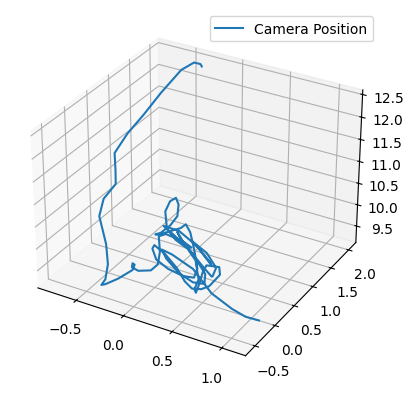

In [25]:
ax = plt.figure().add_subplot(projection='3d')

points = np.array(([f.viewpoint.T for f in sequenceid_to_frame_annotations[sequence_name]]))
ax.plot(points[:, 0], points[:, 1], points[:, 2], label='Camera Position')
ax.legend()

plt.show()

## Training a linear regression model to predict CO3D camera pose from SVD extracted features

### Extracting features

In [2]:
# debug flags
output_videos = True # set to true if you want to output the videos from running SVD 
num_inference_steps = 25 # set to 25 to render the full denoising schedule 
run_one_vid = True # set True to extract features and possibly render only the first 25 frames

In [15]:
# Initialize the CustomStableVideoDiffusionPipeline
pipe = CustomStableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)
pipe.enable_model_cpu_offload()
generator = torch.manual_seed(42)

# Load CO3D dataset annotations (similar to your previous code)
DATA_DIR="/lustre/scratch/diff/datasets/CO3Dv2/"
category_frame_annotations = load_dataclass_jgzip(
    f"{DATA_DIR}/hydrant/frame_annotations.jgz", List[FrameAnnotation]
)

# create a map from sequence name to all the frames with that sequence name
sequenceid_to_frame_annotations = { ann.sequence_name: [] for ann in category_frame_annotations }
for ann in category_frame_annotations:
    sequenceid_to_frame_annotations[ann.sequence_name].append(ann)
    
    

# Define the image transformation pipeline
image_transforms = transforms.Compose([
    transforms.Resize(576),  # Resize to 576x1024
    transforms.CenterCrop((576, 1024)),  # Center crop to 576x1024
    # Add any additional transformations here if needed
])

def load_image(image_path):
    # Load the image from the file
    image = Image.open(image_path).convert('RGB')  # Convert to RGB to ensure 3 color channels
    
    # Apply the transformations to the image
    transformed_image = image_transforms(image)
    
    return transformed_image

# Use the function in your preprocessing step
def preprocess_image(frame_annotation):
    image_path = f"{DATA_DIR}/{frame_annotation.image.path}"
    image = load_image(image_path)
    return image
    

# Initialize lists for camera positions, orientations, and features
all_camera_positions = []
all_camera_orientations = []
all_features = []

selected_sequence_name = list(sequenceid_to_frame_annotations.keys())[0] #27

# Process frames in chunks of 25, including the first frame in each chunk
num_frames = len(sequenceid_to_frame_annotations[selected_sequence_name])
chunk_size = 24  # To ensure we always include the first frame
first_frame_annotation = sequenceid_to_frame_annotations[selected_sequence_name][0]
first_chunk_processed = False
for i in range(0, num_frames, chunk_size):
    # Create a chunk of frames including the first frame
    chunk_annotations = [first_frame_annotation] + sequenceid_to_frame_annotations[selected_sequence_name][i:i + chunk_size]
    if len(chunk_annotations) < chunk_size:
        break

    # Extract camera positions and orientations for the chunk
    chunk_camera_positions = []
    chunk_camera_orientations = []

    for ann in chunk_annotations:
        # ... [same code as before for extracting T and R]
        T = ann.viewpoint.T
        R_matrix = np.array(ann.viewpoint.R)
        euler_angles = R.from_matrix(R_matrix).as_euler('xyz', degrees=True)

        chunk_camera_positions.append(T)
        chunk_camera_orientations.append(euler_angles)

    # Load and preprocess images for the chunk
    chunk_feat_images = [preprocess_image(ann) for ann in chunk_annotations]

    print(f"dbg: {len(chunk_feat_images)}")

    # Extract features using Stable Video Diffusion model for the chunk
    # Extract features with the pipeline
    
    output, extracted_features = pipe(chunk_feat_images[0], decode_chunk_size=8, generator=generator, num_inference_steps=num_inference_steps, feat_images=chunk_feat_images)
    _, features_cond = extracted_features.chunk(2)
    chunk_features = features_cond.cpu().float().numpy()

    if output_videos: 
        frames = output.frames[0]
        export_to_video(frames, f"outputs/CO3D/generated_{i+1}.mp4", fps=7)
        print(f"saved output at outputs/CO3D/generated_{i+1}.mp4")

    # Append to overall lists
    
    
    if not first_chunk_processed:
        all_camera_positions.extend(chunk_camera_positions)
        all_camera_orientations.extend(chunk_camera_orientations)
        all_features.extend(chunk_features)
        first_chunk_processed = True
    else:
        # For subsequent chunks, skip the first frame's features
        all_camera_positions.extend(chunk_camera_positions[1:])
        all_camera_orientations.extend(chunk_camera_orientations[1:])
        all_features.extend(chunk_features[1:]) # Assuming chunk_features is a list of features for the chunk
    if run_one_vid: 
        break

# Convert to numpy arrays for further processing
all_camera_positions = np.array(all_camera_positions)
all_camera_orientations = np.array(all_camera_orientations)
all_features = np.array(all_features)


Loading pipeline components...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]


amani-dbg:  ['CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'DownBlockSpatioTemporal']
dbg: 25


  0%|                                                                                                                                                 | 0/25 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


  4%|█████▍                                                                                                                                   | 1/25 [00:02<00:50,  2.10s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


  8%|██████████▉                                                                                                                              | 2/25 [00:03<00:42,  1.85s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 12%|████████████████▍                                                                                                                        | 3/25 [00:05<00:39,  1.77s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 16%|█████████████████████▉                                                                                                                   | 4/25 [00:07<00:36,  1.74s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 20%|███████████████████████████▍                                                                                                             | 5/25 [00:08<00:34,  1.72s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 24%|████████████████████████████████▉                                                                                                        | 6/25 [00:10<00:32,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 28%|██████████████████████████████████████▎                                                                                                  | 7/25 [00:12<00:30,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 32%|███████████████████████████████████████████▊                                                                                             | 8/25 [00:13<00:28,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 36%|█████████████████████████████████████████████████▎                                                                                       | 9/25 [00:15<00:27,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 40%|██████████████████████████████████████████████████████▍                                                                                 | 10/25 [00:17<00:25,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 44%|███████████████████████████████████████████████████████████▊                                                                            | 11/25 [00:18<00:23,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 48%|█████████████████████████████████████████████████████████████████▎                                                                      | 12/25 [00:20<00:22,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 52%|██████████████████████████████████████████████████████████████████████▋                                                                 | 13/25 [00:22<00:20,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 56%|████████████████████████████████████████████████████████████████████████████▏                                                           | 14/25 [00:24<00:18,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 60%|█████████████████████████████████████████████████████████████████████████████████▌                                                      | 15/25 [00:25<00:16,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 64%|███████████████████████████████████████████████████████████████████████████████████████                                                 | 16/25 [00:27<00:15,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 68%|████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 17/25 [00:29<00:13,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 18/25 [00:30<00:11,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 19/25 [00:32<00:10,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 20/25 [00:34<00:08,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 21/25 [00:35<00:06,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 22/25 [00:37<00:05,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 23/25 [00:39<00:03,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 24/25 [00:41<00:01,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:42<00:00,  1.71s/it]


saved output at outputs/CO3D/generated_1.mp4


In [13]:
selected_sequence_name

'106_12648_23157'

In [5]:
all_features.shape, all_camera_positions.shape, all_camera_orientations.shape

((97, 1280, 9, 16), (97, 3), (97, 3))

### Sanity check for embeddings

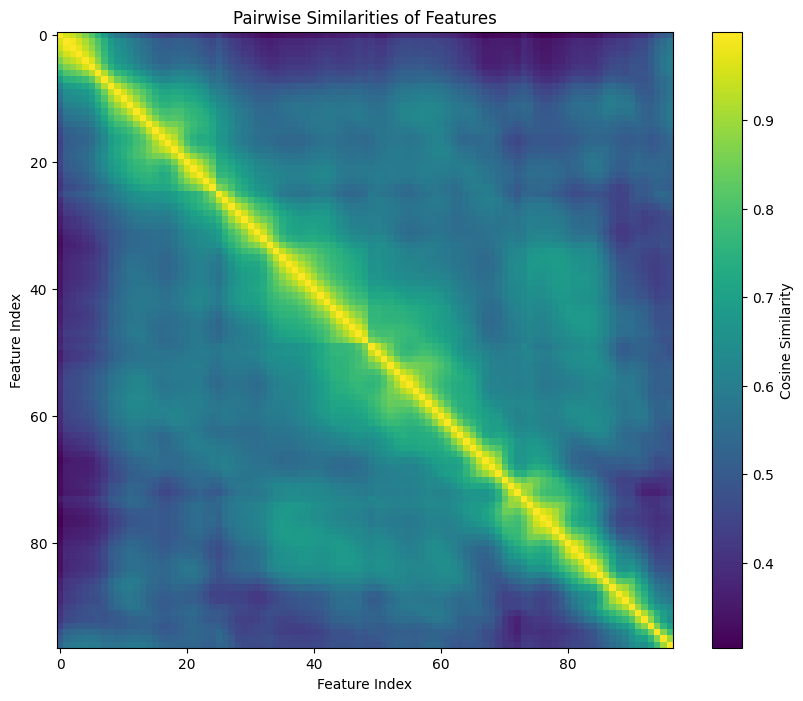

In [7]:
# Assuming 'all_features' is a numpy array of shape (num_samples, num_features, height, width)
# Flatten the features to be of shape (num_samples, num_features * height * width)
flattened_features = all_features.reshape(all_features.shape[0], -1)

# Calculate cosine similarity between all pairs of flattened tensors
similarities = cosine_similarity(flattened_features)

# Plot the pairwise similarities
plt.figure(figsize=(10, 8))
plt.imshow(similarities, cmap='viridis', interpolation='none')
plt.colorbar(label='Cosine Similarity')
plt.title('Pairwise Similarities of Features')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.show()


### Sanity check for interpolating between frames using SVD

#### With masking 

In [2]:
# debug flags
output_videos = True # set to true if you want to output the videos from running SVD 
num_inference_steps = 25# set to 25 to render the full denoising schedule 
run_one_vid = True # set True to extract features and possibly render only the first 25 frames
mask_latents_randomly = 0.8 # e.g., .5=50% of the frames in each chunk
mask_latents_range = None

In [3]:
# Initialize the CustomStableVideoDiffusionPipeline
pipe = CustomStableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)
pipe.enable_model_cpu_offload()
generator = torch.manual_seed(42)

# Load CO3D dataset annotations (similar to your previous code)
DATA_DIR="/lustre/scratch/diff/datasets/CO3Dv2/"
category_frame_annotations = load_dataclass_jgzip(
    f"{DATA_DIR}/hydrant/frame_annotations.jgz", List[FrameAnnotation]
)

# create a map from sequence name to all the frames with that sequence name
sequenceid_to_frame_annotations = { ann.sequence_name: [] for ann in category_frame_annotations }
for ann in category_frame_annotations:
    sequenceid_to_frame_annotations[ann.sequence_name].append(ann)
    
    

# Define the image transformation pipeline
image_transforms = transforms.Compose([
    transforms.Resize(576),  # Resize to 576x1024
    transforms.CenterCrop((576, 1024)),  # Center crop to 576x1024
    # Add any additional transformations here if needed
])

def load_image(image_path):
    # Load the image from the file
    image = Image.open(image_path).convert('RGB')  # Convert to RGB to ensure 3 color channels
    
    # Apply the transformations to the image
    transformed_image = image_transforms(image)
    
    return transformed_image

# Use the function in your preprocessing step
def preprocess_image(frame_annotation):
    image_path = f"{DATA_DIR}/{frame_annotation.image.path}"
    image = load_image(image_path)
    return image


    

# Initialize lists for camera positions, orientations, and features
all_camera_positions = []
all_camera_orientations = []
all_features = []

selected_sequence_name = list(sequenceid_to_frame_annotations.keys())[0] #27

# Process frames in chunks of 25, including the first frame in each chunk
num_frames = len(sequenceid_to_frame_annotations[selected_sequence_name])
chunk_size = 24  # To ensure we always include the first frame
first_frame_annotation = sequenceid_to_frame_annotations[selected_sequence_name][0]
first_chunk_processed = False



for i in range(0, num_frames, chunk_size):
    # Create a chunk of frames including the first frame
    chunk_annotations = [first_frame_annotation] + sequenceid_to_frame_annotations[selected_sequence_name][i:i + chunk_size]
    if len(chunk_annotations) < chunk_size:
        break

    # Extract camera positions and orientations for the chunk
    chunk_camera_positions = []
    chunk_camera_orientations = []

    for ann in chunk_annotations:
        # ... [same code as before for extracting T and R]
        T = ann.viewpoint.T
        R_matrix = np.array(ann.viewpoint.R)
        euler_angles = R.from_matrix(R_matrix).as_euler('xyz', degrees=True)

        chunk_camera_positions.append(T)
        chunk_camera_orientations.append(euler_angles)

    # Load and preprocess images for the chunk
    chunk_feat_images = [preprocess_image(ann) for ann in chunk_annotations]

    print(f"dbg: {len(chunk_feat_images)}")

    # Extract features using Stable Video Diffusion model for the chunk
    # Extract features with the pipeline
    
    output, extracted_features = pipe(chunk_feat_images[0], decode_chunk_size=8, generator=generator, num_inference_steps=num_inference_steps, feat_images=chunk_feat_images, mask_latents_randomly=mask_latents_randomly, mask_latents_range=mask_latents_range)
    _, features_cond = extracted_features.chunk(2)
    chunk_features = features_cond.cpu().float().numpy()

    if output_videos: 
        frames = output.frames[0]
        export_to_video(frames, f"outputs/CO3D/generated_{i+1}.mp4", fps=7)
        print(f"saved output at outputs/CO3D/generated_{i+1}.mp4")

    # Append to overall lists
    
    
    if not first_chunk_processed:
        all_camera_positions.extend(chunk_camera_positions)
        all_camera_orientations.extend(chunk_camera_orientations)
        all_features.extend(chunk_features)
        first_chunk_processed = True
    else:
        # For subsequent chunks, skip the first frame's features
        all_camera_positions.extend(chunk_camera_positions[1:])
        all_camera_orientations.extend(chunk_camera_orientations[1:])
        all_features.extend(chunk_features[1:]) # Assuming chunk_features is a list of features for the chunk
    if run_one_vid: 
        break

# Convert to numpy arrays for further processing
all_camera_positions = np.array(all_camera_positions)
all_camera_orientations = np.array(all_camera_orientations)
all_features = np.array(all_features)


Loading pipeline components...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.07it/s]


amani-dbg:  ['CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'DownBlockSpatioTemporal']
dbg: 25
dbg: masking latents randomly


  0%|                                                                                                                                                 | 0/25 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])


  4%|█████▍                                                                                                                                   | 1/25 [00:02<01:04,  2.69s/it]

dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])
amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


  8%|██████████▉                                                                                                                              | 2/25 [00:04<00:48,  2.10s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 12%|████████████████▍                                                                                                                        | 3/25 [00:06<00:42,  1.91s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 16%|█████████████████████▉                                                                                                                   | 4/25 [00:07<00:38,  1.83s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 20%|███████████████████████████▍                                                                                                             | 5/25 [00:09<00:35,  1.78s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 24%|████████████████████████████████▉                                                                                                        | 6/25 [00:11<00:33,  1.75s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 28%|██████████████████████████████████████▎                                                                                                  | 7/25 [00:12<00:31,  1.73s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 32%|███████████████████████████████████████████▊                                                                                             | 8/25 [00:14<00:29,  1.72s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 36%|█████████████████████████████████████████████████▎                                                                                       | 9/25 [00:16<00:27,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 40%|██████████████████████████████████████████████████████▍                                                                                 | 10/25 [00:17<00:25,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 44%|███████████████████████████████████████████████████████████▊                                                                            | 11/25 [00:19<00:23,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 48%|█████████████████████████████████████████████████████████████████▎                                                                      | 12/25 [00:21<00:22,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 52%|██████████████████████████████████████████████████████████████████████▋                                                                 | 13/25 [00:23<00:20,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 56%|████████████████████████████████████████████████████████████████████████████▏                                                           | 14/25 [00:24<00:18,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 60%|█████████████████████████████████████████████████████████████████████████████████▌                                                      | 15/25 [00:26<00:17,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 64%|███████████████████████████████████████████████████████████████████████████████████████                                                 | 16/25 [00:28<00:15,  1.70s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 68%|████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 17/25 [00:29<00:13,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 18/25 [00:31<00:11,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 19/25 [00:33<00:10,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 20/25 [00:34<00:08,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 21/25 [00:36<00:06,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 22/25 [00:38<00:05,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 23/25 [00:40<00:03,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 24/25 [00:41<00:01,  1.71s/it]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:43<00:00,  1.74s/it]


saved output at outputs/CO3D/generated_1.mp4


## Train Classifier

#### Split 80/20 train/test

In [ ]:
# Determine the split index
split_index = int(len(all_features) * 0.8)

# Split the features and labels
X_train = all_features[:split_index]
y_train = all_camera_positions[:split_index]
X_test = all_features[split_index:]
y_test = all_camera_positions[split_index:]

# Apply Global Average Pooling (GAP)
gap_features_train = torch.mean(torch.tensor(X_train), dim=[2, 3])
gap_features_test = torch.mean(torch.tensor(X_test), dim=[2, 3])

# Linear Regression model
regressor = LinearRegression()
regressor.fit(gap_features_train, y_train)

# Evaluate the model on both training and testing sets
train_predictions = regressor.predict(gap_features_train)
test_predictions = regressor.predict(gap_features_test)

# Calculate MSE for both sets
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
print("Training Mean Squared Error:", train_mse)
print("Testing Mean Squared Error:", test_mse)


#### Split odd/even train/test

In [7]:


# Split the features and labels
X_train = all_features[::2]
y_train = all_camera_positions[::2]
X_test = all_features[1::2]
y_test = all_camera_positions[1::2]

# Apply Global Average Pooling (GAP)
gap_features_train = torch.mean(torch.tensor(X_train), dim=[2, 3])
gap_features_test = torch.mean(torch.tensor(X_test), dim=[2, 3])

# Linear Regression model
regressor = LinearRegression()
regressor.fit(gap_features_train, y_train)

# Evaluate the model on both training and testing sets
train_predictions = regressor.predict(gap_features_train)
test_predictions = regressor.predict(gap_features_test)

# Calculate MSE for both sets
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
print("Training Mean Squared Error:", train_mse)
print("Testing Mean Squared Error:", test_mse)


Training Mean Squared Error: 1.6200948382937602e-12
Testing Mean Squared Error: 0.0050337489269797545


#### Plotting results

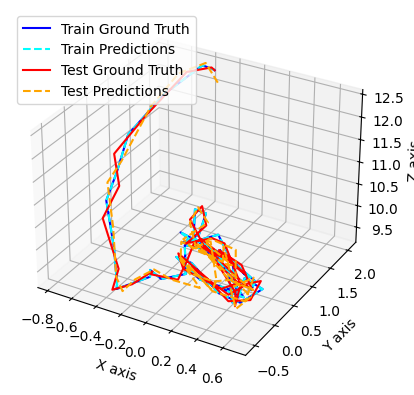

In [8]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the ground truth for the training set
ax.plot(y_train[:, 0], y_train[:, 1], y_train[:, 2], color='blue', label='Train Ground Truth', linestyle='-')

# Plotting the predictions for the training set
ax.plot(train_predictions[:, 0], train_predictions[:, 1], train_predictions[:, 2], color='cyan', label='Train Predictions', linestyle='dashed')

# Plotting the ground truth for the testing set
ax.plot(y_test[:, 0], y_test[:, 1], y_test[:, 2], color='red', label='Test Ground Truth', linestyle='-')

# Plotting the predictions for the testing set
ax.plot(test_predictions[:, 0], test_predictions[:, 1], test_predictions[:, 2], color='orange', label='Test Predictions', linestyle='dashed')

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

plt.show()


## Training linear regressor across multiple scenes

In [36]:
# debug flags
output_videos = False # set to true if you want to output the videos from running SVD 
num_inference_steps = 1 # set to 25 to render the full denoising schedule 
run_one_vid = False # set True to extract features for only one iteration 
mask_latents_randomly = None # e.g., .5=50% of the frames in each chunk
mask_latents_range = None

In [4]:
!nvidia-smi

Fri Dec 22 14:46:47 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           Off| 00000000:01:00.0 Off |                    0 |
| N/A   39C    P0               46W / 300W|      0MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [5]:

# Initialize the CustomStableVideoDiffusionPipeline
pipe = CustomStableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)
pipe.enable_model_cpu_offload()
generator = torch.manual_seed(42)

# Load CO3D dataset annotations (similar to your previous code)
DATA_DIR="/lustre/scratch/diff/datasets/CO3Dv2/"
category_frame_annotations = load_dataclass_jgzip(
    f"{DATA_DIR}/hydrant/frame_annotations.jgz", List[FrameAnnotation]
)

# create a map from sequence name to all the frames with that sequence name
sequenceid_to_frame_annotations = { ann.sequence_name: [] for ann in category_frame_annotations }
for ann in category_frame_annotations:
    sequenceid_to_frame_annotations[ann.sequence_name].append(ann)
    
    

# Define the image transformation pipeline
image_transforms = transforms.Compose([
    transforms.Resize(576),  # Resize to 576x1024
    transforms.CenterCrop((576, 1024)),  # Center crop to 576x1024
    # Add any additional transformations here if needed
])

def load_image(image_path):
    # Load the image from the file
    image = Image.open(image_path).convert('RGB')  # Convert to RGB to ensure 3 color channels
    
    # Apply the transformations to the image
    transformed_image = image_transforms(image)
    
    return transformed_image

# Use the function in your preprocessing step
def preprocess_image(frame_annotation):
    image_path = f"{DATA_DIR}/{frame_annotation.image.path}"
    image = load_image(image_path)
    return image
    
def compute_relative_position(position1, position2):
    """ Compute the relative position from one pose to another """
    position1 = np.array(position1)
    position2 = np.array(position2)
    relative_position = position2 - position1
    return relative_position


# Prepare data for training
X = []
y = []


# Initialize lists for camera positions, orientations, and features
all_camera_positions = []
all_camera_orientations = []
all_features = []

selected_sequence_name = list(sequenceid_to_frame_annotations.keys())[0] #27

# Process frames in chunks of 25, including the first frame in each chunk
num_frames = len(sequenceid_to_frame_annotations[selected_sequence_name])
chunk_size = 25  # To ensure we always include the first frame
first_frame_annotation = sequenceid_to_frame_annotations[selected_sequence_name][0]
first_chunk_processed = False

# Get a list of all sequence names
all_sequence_names = list(sequenceid_to_frame_annotations.keys())

# Determine the split index for 80% training and 20% testing
split_index = int(len(all_sequence_names) * 0.2)

test_split_index = int(split_index * 0.2) + split_index

# Split the sequence names into training and testing sets
train_sequence_names = all_sequence_names[:split_index]
test_sequence_names = all_sequence_names[split_index:test_split_index]

# Initialize the SGDRegressor for incremental learning
regressor = SGDRegressor(max_iter=1, tol=None, learning_rate='constant', eta0=0.001)

# Function to process scenes (to be used for both training and testing)
def process_scenes(scene_names, regressor=None, training=True, num_samples_per_scene=50):
    X, y = [], []
    for sequence_name in tqdm(scene_names, desc="Processing Scenes"):
        annotations = sequenceid_to_frame_annotations[sequence_name]
        num_frames = len(annotations)

        # Randomly select a start index for a chunk within the scene
        if num_frames > chunk_size:
            i = random.randint(0, num_frames - chunk_size)
        else:
            continue  # Skip scenes that don't have enough frames


        chunk_annotations = annotations[i:i + chunk_size]
        chunk_feat_images = [preprocess_image(ann) for ann in chunk_annotations]
        _, extracted_features = pipe(chunk_feat_images[0], decode_chunk_size=8, generator=generator, num_inference_steps=num_inference_steps, feat_images=chunk_feat_images)
        _, chunk_features = extracted_features.chunk(2)
        chunk_features = chunk_features.cpu().float().numpy()
        cur_samples_per_scene = 0
        for j in range(len(chunk_features)):
            for k in range(j + 1, len(chunk_features)):
                position1 = chunk_annotations[j].viewpoint.T
                position2 = chunk_annotations[k].viewpoint.T
                relative_position = compute_relative_position(position1, position2)

                combined_features = np.concatenate((chunk_features[j].flatten(), chunk_features[k].flatten()))
                X.append(combined_features)
                y.append(relative_position)
                cur_samples_per_scene+=1
                if cur_samples_per_scene == num_samples_per_scene: 
                    continue
            if cur_samples_per_scene == num_samples_per_scene: 
                    continue
                

                # if training:
                #     # Incrementally fit the model
                #     regressor.partial_fit(combined_features.reshape(1, -1), relative_position.reshape(1, -1))
                # else:
                #     X.append(combined_features)
                #     y.append(relative_position)

    return X, y

# Process training scenes
X_train, y_train = process_scenes(train_sequence_names, regressor=regressor, training=True)

# Process testing scenes
X_test, y_test = process_scenes(test_sequence_names, training=False)

Loading pipeline components...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.21it/s]


amani-dbg:  ['CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'DownBlockSpatioTemporal']


  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/it]

dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Processing Scenes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [02:11<00:00, 10.97s/it]


In [6]:
len(X_train)

18300

In [9]:
!nvidia-smi

Thu Dec 21 00:35:41 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           Off| 00000000:01:00.0 Off |                    0 |
| N/A   51C    P0               75W / 300W|  60143MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [15]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor

# Initialize the base SGDRegressor
sgd_regressor = SGDRegressor(max_iter=1, tol=None, learning_rate='constant', eta0=0.01)

# Wrap it in a MultiOutputRegressor for multi-target regression
multioutput_regressor = MultiOutputRegressor(sgd_regressor)

# Define the batch size for incremental learning
batch_size = 100  # You can adjust this based on your memory capacity

Training multioutput regressor: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [01:12<00:00,  2.51it/s]


In [16]:
# Manually iterate over the training data in batches
for i in tqdm(range(0, len(X_train), batch_size), desc="Training multioutput regressor"):
    batch_X_train = X_train[i:i + batch_size]
    batch_y_train = y_train[i:i + batch_size]
    multioutput_regressor.partial_fit(batch_X_train, batch_y_train)



Training multioutput regressor: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [01:13<00:00,  2.50it/s]


In [10]:
_X_test=X_test
_y_test=y_test


In [ ]:
X_test= X_train

In [11]:
len(_X_test), len(_y_test)

(3600, 3600)

In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

def evaluate_model_in_batches(model, X_data, y_data, batch_size):
    mse_total = 0
    total_samples = 0

    for i in tqdm(range(0, len(X_data), batch_size)):
        batch_X = X_data[i:i + batch_size]
        batch_y = y_data[i:i + batch_size]

        predictions = model.predict(batch_X)
        mse_batch = mean_squared_error(batch_y, predictions)

        mse_total += mse_batch * len(batch_X)
        total_samples += len(batch_X)

    return mse_total / total_samples


In [17]:

# Define the batch size for evaluation
eval_batch_size = 100  # Adjust as needed

# Evaluate the training data
train_mse = evaluate_model_in_batches(multioutput_regressor, X_train, y_train, eval_batch_size)
print("Training Mean Squared Error:", train_mse)

# Evaluate the testing data
test_mse = evaluate_model_in_batches(multioutput_regressor, X_test, y_test, eval_batch_size)
print("Testing Mean Squared Error:", test_mse)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:42<00:00,  4.26it/s]


Training Mean Squared Error: 1.893711386860359e+36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.90it/s]

Testing Mean Squared Error: 2.315192331366082e+36


In [22]:
len(X_train)

18300

In [7]:
from sklearn.linear_model import LinearRegression

small_X_train = X_train[:4000]
small_y_train = y_train[:4000]

# Test with a simple linear regression model
simple_regressor = LinearRegression()
simple_regressor.fit(small_X_train, small_y_train)

# Evaluate the simple model
simple_train_predictions = simple_regressor.predict(small_X_train)
simple_train_mse = mean_squared_error(small_y_train, simple_train_predictions)
print("Simple Model Training Mean Squared Error:", simple_train_mse)


Simple Model Training Mean Squared Error: 3.295358213585044e-11


In [8]:
train_predictions = simple_regressor.predict(small_X_train[:200])
train_mse = mean_squared_error(small_y_train[:200], train_predictions)
print("Testing Subset Mean Squared Error:", train_mse)

Testing Subset Mean Squared Error: 3.9656916252008476e-11


In [108]:

def calculate_stats(data, label):
    data_norm = norm(data)
    data_mean = np.mean(data, axis=0)
    data_median = np.median(data, axis=0)
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)

    print(f"Stats for {label}:")
    print(f"Norm: {data_norm}")
    print(f"Mean: {data_mean}")
    print(f"Median: {data_median}")
    print(f"Min: {data_min}")
    print(f"Max: {data_max}\n")
    
def plot_3d_subset(y_true, y_pred, start_index=0, subset_size=25):
    """
    Plots a 3D comparison of true values and predictions for a specified subset.

    :param y_true: Array of true values.
    :param y_pred: Array of predicted values.
    :param start_index: Starting index for the subset to plot.
    :param subset_size: Number of data points in the subset to plot.
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Selecting the subset
    end_index = start_index + subset_size
    y_true_subset = y_true[start_index:end_index]
    y_pred_subset = y_pred[start_index:end_index]

    calculate_stats(y_true_subset, "Ground Truth")
    calculate_stats(y_pred_subset, "Predictions")


    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the ground truth for the subset
    ax.plot(y_true_subset[:, 0], y_true_subset[:, 1], y_true_subset[:, 2], color='red', label='Ground Truth', linestyle='-')

    # Plotting the predictions for the subset
    ax.plot(y_pred_subset[:, 0], y_pred_subset[:, 1], y_pred_subset[:, 2], color='orange', label='Predictions', linestyle='dashed')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()
    plt.title(f"3D Plot from index {start_index} to {end_index}")
    plt.show()



def plot_3d_subset_scaled(y_true, y_pred, start_index=0, subset_size=25):
    from sklearn.preprocessing import MinMaxScaler
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Selecting the subset
    end_index = start_index + subset_size
    y_true_subset = y_true[start_index:end_index]
    y_pred_subset = y_pred[start_index:end_index]

    # Min-Max scaling both the ground truth and predictions
    scaler = MinMaxScaler()
    y_true_subset_scaled = scaler.fit_transform(y_true_subset)
    y_pred_subset_scaled = 4* scaler.transform(y_pred_subset)

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the scaled ground truth for the subset
    ax.plot(y_true_subset_scaled[:, 0], y_true_subset_scaled[:, 1], y_true_subset_scaled[:, 2], color='red', label='Scaled Ground Truth', linestyle='-')

    # Plotting the scaled predictions for the subset
    ax.plot(y_pred_subset_scaled[:, 0], y_pred_subset_scaled[:, 1], y_pred_subset_scaled[:, 2], color='orange', label='Scaled Predictions', linestyle='dashed')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()
    plt.title(f"Scaled 3D Plot from index {start_index} to {end_index}")
    plt.show()



In [99]:
len(X_test)

3600

range test data: 3300 3600
Testing Subset Mean Squared Error: 0.013978020788075024
Stats for Ground Truth:
Norm: 2.5559167015519693
Mean: [-0.14972662 -0.31699641 -0.34566883]
Median: [-0.17655686 -0.366561   -0.35717106]
Min: [-0.22246211 -0.4138025  -0.50819492]
Max: [-0.02062613 -0.03158396 -0.05865526]

Stats for Predictions:
Norm: 1.5051189661026
Mean: [-0.09955552 -0.255286   -0.02122906]
Median: [-0.10238623 -0.29687566 -0.02586754]
Min: [-0.17039238 -0.39875844 -0.07009995]
Max: [ 0.00369531 -0.03354251  0.0698455 ]



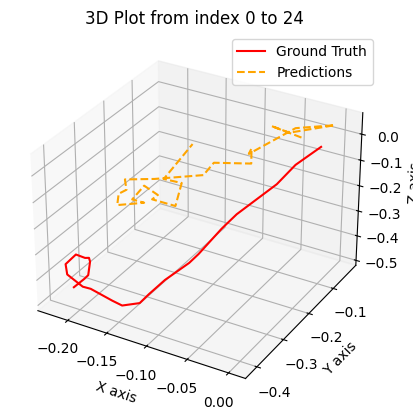

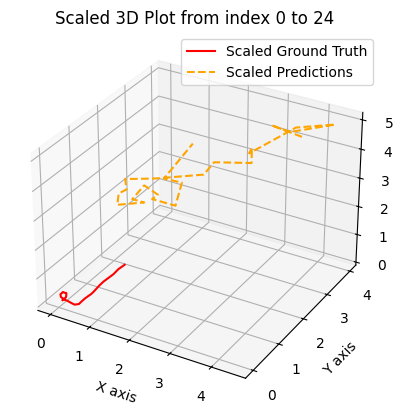

In [121]:
# Evaluate the model on the testing subset

j = 11
print("range test data:", j*300,(j*300)+300)
small_X_test = X_test[j*300:(j*300)+300]
small_y_test = y_test[j*300:(j*300)+300]


test_predictions = simple_regressor.predict(small_X_test)
test_mse = mean_squared_error(small_y_test, test_predictions)
print("Testing Subset Mean Squared Error:", test_mse)

plot_3d_subset(small_y_test, test_predictions, start_index=0, subset_size=24)
plot_3d_subset_scaled(small_y_test, test_predictions, start_index=0, subset_size=24)

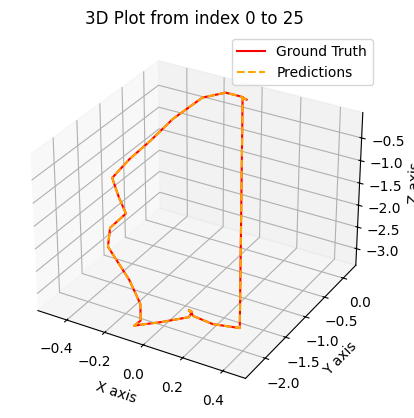

In [23]:
plot_3d_subset(small_y_train[:200], train_predictions, start_index=0, subset_size=25)

In [20]:
from sklearn.linear_model import SGDRegressor

# Test with SGDRegressor directly
sgd_regressor_test = SGDRegressor(max_iter=1000, tol=1e-3, learning_rate='constant', eta0=0.001, verbose=1)
sgd_regressor_test.fit(small_X_train, small_y_train[:, 0])  # Test with the first target dimension

# Evaluate the SGDRegressor model
sgd_train_predictions = sgd_regressor_test.predict(small_X_train)
sgd_train_mse = mean_squared_error(small_y_train[:, 0], sgd_train_predictions)
print("SGDRegressor Training Mean Squared Error:", sgd_train_mse)


TypeError: list indices must be integers or slices, not tuple

In [21]:
small_y_train_array = np.array(small_y_train)

# Test with SGDRegressor directly
sgd_regressor_test = SGDRegressor(max_iter=1000, tol=1e-3, learning_rate='constant', eta0=0.001, verbose=1)
sgd_regressor_test.fit(small_X_train, small_y_train_array[:, 0])  # Test with the first target dimension

# Evaluate the SGDRegressor model
sgd_train_predictions = sgd_regressor_test.predict(small_X_train)
sgd_train_mse = mean_squared_error(small_y_train_array[:, 0], sgd_train_predictions)
print("SGDRegressor Training Mean Squared Error:", sgd_train_mse)

-- Epoch 1
Norm: 24127531686434.68, NNZs: 368640, Bias: -1014705073.528606, T: 100, Avg. loss: 10479223401149532629590822887620608.000000
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 36113992834562.33, NNZs: 368640, Bias: -1014705073.528606, T: 200, Avg. loss: 10459541289870042177045244252520448.000000
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 39337525071991.38, NNZs: 368640, Bias: -1014705073.528606, T: 300, Avg. loss: 13796588219858692318763972003102720.000000
Total training time: 0.24 seconds.
-- Epoch 4
Norm: 56396144843497.37, NNZs: 368640, Bias: -1014705073.528606, T: 400, Avg. loss: 9574347965021842448634813171630080.000000
Total training time: 0.32 seconds.
-- Epoch 5
Norm: 47683920695395.97, NNZs: 368640, Bias: -1014705073.528606, T: 500, Avg. loss: 13929368878819788645846368137510912.000000
Total training time: 0.40 seconds.
-- Epoch 6
Norm: 47224283439713.95, NNZs: 368640, Bias: -1014705073.528606, T: 600, Avg. loss: 10127905767196073596149052223782912.00000

## Pytorch training on CO3D

In [4]:
def global_average_pooling(features):
    # Apply GAP to reduce each feature map to a single number per channel
    return F.adaptive_avg_pool2d(features, (1)).view(features.size(0))

def normalize_positions(positions):
    # L2 normalization (Euclidean norm)
    return F.normalize(positions, p=2, dim=1)


DATA_DIR="/lustre/scratch/diff/datasets/CO3Dv2/"

pipe = CustomStableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)

category_frame_annotations = load_dataclass_jgzip(
    f"{DATA_DIR}/hydrant/frame_annotations.jgz", List[FrameAnnotation]
)

category_sequence_annotations = load_dataclass_jgzip(
    f"{DATA_DIR}/hydrant/sequence_annotations.jgz", List[FrameAnnotation]
)


# create a map from sequence name to all the frames with that sequence name
sequenceid_to_frame_annotations = { ann.sequence_name: [] for ann in category_frame_annotations }
for ann in category_frame_annotations:
    sequenceid_to_frame_annotations[ann.sequence_name].append(ann)


pipe.enable_model_cpu_offload()
generator = torch.manual_seed(42)



class CO3DDataset(Dataset):
    def __init__(self, scene_annotations, scene_names, data_dir, pipeline, transform=None, use_gap = True, train_percentage = 0.8, is_train_split = True, num_samples=25):
        self.scene_annotations = scene_annotations
        self.data_dir = data_dir
        self.pipeline = pipeline
        self.transform = transform
        self.num_samples = num_samples
        self.use_gap = use_gap
        train_length = int(len(scene_names) * train_percentage)
        
        if is_train_split: 
            # use train split 
            self.scene_names = scene_names[:train_length]
        else: self.scene_names = scene_names[train_length:]

    def __len__(self):
        return len(self.scene_names)

    def __getitem__(self, idx):
        
        scene = self.scene_names[idx]
        annotations = self.scene_annotations[scene]
        
        if len(annotations) < self.num_samples:
            raise ValueError(f"Scene {scene} does not have enough annotations.")
        
        # Randomly sample annotations
        sampled_anns = random.sample(annotations, self.num_samples)

        # Process images and extract features
        imgs, positions = [], []
        for ann in sampled_anns:
            img = self.process_image(ann)
            imgs.append(img)
            positions.append(torch.tensor(ann.viewpoint.T, dtype=torch.float32))

        # Feature extraction with pipeline
        _, extracted_features = self.pipeline(imgs[0], decode_chunk_size=8, generator=torch.manual_seed(42), num_inference_steps=1, feat_images=imgs)
        _, features_cond = extracted_features.chunk(2)
        features = features_cond.cpu().float()

       # Initialize lists for aggregated features and positions
        aggregated_features, aggregated_positions = [], []
    
        # Create all pairs and aggregate features and positions
        for i, j in itertools.combinations(range(self.num_samples), 2):
            relative_pos = positions[j] - positions[i]
            # GAP both features
            if self.use_gap: 
                gap_features_1, gap_features_2 = global_average_pooling(features[i]), global_average_pooling(features[j])
                features_cat = torch.cat((gap_features_1, gap_features_2), dim = 0)
            else: 
                flattened_features_1, flattened_features_2 = features[i].reshape(-1), features[j].reshape(-1)
                features_cat = torch.cat((flattened_features_1, flattened_features_2), dim = 0)
            
            # Append to the aggregated lists
            aggregated_features.append(features_cat)
            aggregated_positions.append(relative_pos)
            
        # Convert lists to tensors and reshape to (-1)
        aggregated_features_tensor = torch.stack(aggregated_features).reshape(300, -1)
        aggregated_positions_tensor = torch.stack(aggregated_positions).reshape(300, -1)
    
        return aggregated_features_tensor, aggregated_positions_tensor

    def process_image(self, ann):
        image_path = os.path.join(self.data_dir, ann.image.path)
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations
transforms = Compose([
    Resize(576),
    CenterCrop((576, 1024)),
])

# Create the dataset and dataloader
co3d_dataset = CO3DDataset(sequenceid_to_frame_annotations, [x.sequence_name for x in category_sequence_annotations], DATA_DIR, pipe, transform=transforms, use_gap = False)
co3d_dataloader = DataLoader(co3d_dataset, batch_size=1)


Loading pipeline components...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.50it/s]


amani-dbg:  ['CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'CrossAttnDownBlockSpatioTemporal', 'DownBlockSpatioTemporal']


In [32]:
sample_batch = next(iter(co3d_dataloader))
# Assuming the batch returns a list of tuples (features1, features2, relative_pos)
# and each feature tensor has a shape of [num_samples, feature_dim]
sample_feature = sample_batch[0][0][0]  # Get the first feature tensor from the first pair

# Calculate the input size for the model (double the size of a single feature set)
input_size = sample_feature.shape[0]
print("dbg: feature shape", sample_feature.shape)
print("dbg: feature_size: ",input_size)

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it]


dbg: feature shape torch.Size([368640])
dbg: feature_size:  368640


In [8]:
# Define a simple linear regression model
class SimpleRegressor(nn.Module):
    def __init__(self, input_size):
        super(SimpleRegressor, self).__init__()
        self.linear = nn.Linear(input_size, 3)  # Predicting 3D relative position

    def forward(self, x):
        return self.linear(x)


In [ ]:
# Define and initialize the simple linear regression model with the calculated input size
model = SimpleRegressor(input_size=input_size).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [10]:
# optionally load checkpoint 
checkpoint = torch.load('model_checkpoint_2.pth')
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:

model = model.to(device)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [8]:
 list(iter(model.named_parameters()))

[('linear.weight',
  Parameter containing:
  tensor([[-8.2050e-04, -1.3023e-03, -7.7801e-04,  ..., -8.7432e-04,
            7.1786e-04, -6.8916e-04],
          [-3.2381e-04, -1.3186e-03,  3.4083e-04,  ..., -1.2975e-03,
            1.0387e-03, -3.8703e-04],
          [ 1.2410e-03,  6.8778e-07,  1.1867e-03,  ...,  7.6419e-04,
           -1.0318e-03,  1.4828e-03]], device='cuda:0', requires_grad=True)),
 ('linear.bias',
  Parameter containing:
  tensor([ 0.0016, -0.0012, -0.0003], device='cuda:0', requires_grad=True))]

In [9]:
# train flags

num_epochs = 1

### Training

In [13]:

losses = []
# Training loop with GAP and L2 normalization
for epoch in range(num_epochs):
    model.train()
    for idx, batch in enumerate(tqdm(co3d_dataloader, desc="Training linear pose regression")):
        # Prepare data
        features, relative_pos = batch
        features = features.squeeze().to(device)
        relative_pos = relative_pos.squeeze().to(device)
        
        print(f"dbg: {features.shape=}, {relative_pos.shape=}")
        print(f"dbg: {features.device=}, {relative_pos.device=}")

        # Normalize features and positions
        # norm_features1 = normalize_features(gap_features1)
        # norm_features2 = normalize_features(gap_features2)
        norm_relative_pos = normalize_positions(relative_pos)
    
        # Forward pass
        outputs = model(features)
        
        norm_outputs = normalize_positions(outputs)
        print(f"dbg: {norm_relative_pos.shape=}, {outputs.shape=}, {norm_outputs.shape=}")
        print(f"dbg: {norm_relative_pos.device=}, {outputs.device=}, {norm_outputs.device=}")

        loss = criterion(norm_outputs, norm_relative_pos)
        if idx % 10 == 0: 
            losses.append(loss)
        
        print("Loss: ", loss)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Assuming 'model' is your model and 'optimizer' is your optimizer

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    # you can add more items to the checkpoint if needed, like epoch number, loss, etc.
}

torch.save(checkpoint, 'model_checkpoint_2.pth')


  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   0%|▎                                                                                                      | 1/307 [00:10<51:42, 10.14s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   1%|▋                                                                                                      | 2/307 [00:20<52:10, 10.26s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   1%|█                                                                                                      | 3/307 [00:30<52:03, 10.27s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   1%|█▎                                                                                                     | 4/307 [00:41<52:26, 10.38s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   2%|█▋                                                                                                     | 5/307 [00:51<52:34, 10.44s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   2%|██                                                                                                     | 6/307 [01:02<52:30, 10.47s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   2%|██▎                                                                                                    | 7/307 [01:12<52:03, 10.41s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   3%|██▋                                                                                                    | 8/307 [01:23<51:59, 10.43s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   3%|███                                                                                                    | 9/307 [01:33<52:04, 10.48s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   3%|███▎                                                                                                  | 10/307 [01:44<51:51, 10.48s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   4%|███▋                                                                                                  | 11/307 [01:54<51:42, 10.48s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   4%|███▉                                                                                                  | 12/307 [02:05<51:42, 10.52s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   4%|████▎                                                                                                 | 13/307 [02:15<51:18, 10.47s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   5%|████▋                                                                                                 | 14/307 [02:26<51:12, 10.49s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   5%|████▉                                                                                                 | 15/307 [02:36<50:51, 10.45s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   5%|█████▎                                                                                                | 16/307 [02:46<50:26, 10.40s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   6%|█████▋                                                                                                | 17/307 [02:57<50:18, 10.41s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   6%|█████▉                                                                                                | 18/307 [03:07<49:33, 10.29s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   6%|██████▎                                                                                               | 19/307 [03:17<49:19, 10.28s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|██████▋                                                                                               | 20/307 [03:28<49:31, 10.35s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|██████▉                                                                                               | 21/307 [03:38<49:35, 10.40s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|███████▎                                                                                              | 22/307 [03:49<49:30, 10.42s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   7%|███████▋                                                                                              | 23/307 [03:59<49:17, 10.42s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   8%|███████▉                                                                                              | 24/307 [04:09<49:09, 10.42s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   8%|████████▎                                                                                             | 25/307 [04:20<48:52, 10.40s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   8%|████████▋                                                                                             | 26/307 [04:30<48:39, 10.39s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   9%|████████▉                                                                                             | 27/307 [04:41<48:35, 10.41s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   9%|█████████▎                                                                                            | 28/307 [04:51<47:48, 10.28s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:   9%|█████████▋                                                                                            | 29/307 [05:01<47:40, 10.29s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  10%|█████████▉                                                                                            | 30/307 [05:11<47:49, 10.36s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  10%|██████████▎                                                                                           | 31/307 [05:22<47:31, 10.33s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  10%|██████████▋                                                                                           | 32/307 [05:32<47:11, 10.29s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  11%|██████████▉                                                                                           | 33/307 [05:42<47:02, 10.30s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  11%|███████████▎                                                                                          | 34/307 [05:53<47:05, 10.35s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  11%|███████████▋                                                                                          | 35/307 [06:03<47:02, 10.38s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  12%|███████████▉                                                                                          | 36/307 [06:13<46:53, 10.38s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  12%|████████████▎                                                                                         | 37/307 [06:24<46:29, 10.33s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  12%|████████████▋                                                                                         | 38/307 [06:34<46:16, 10.32s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  13%|████████████▉                                                                                         | 39/307 [06:44<46:09, 10.33s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  13%|█████████████▎                                                                                        | 40/307 [06:55<46:13, 10.39s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  13%|█████████████▌                                                                                        | 41/307 [07:06<46:54, 10.58s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  14%|█████████████▉                                                                                        | 42/307 [07:16<46:12, 10.46s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  14%|██████████████▎                                                                                       | 43/307 [07:26<45:53, 10.43s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  14%|██████████████▌                                                                                       | 44/307 [07:37<45:39, 10.41s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  15%|██████████████▉                                                                                       | 45/307 [07:47<45:17, 10.37s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  15%|███████████████▎                                                                                      | 46/307 [07:57<44:52, 10.32s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  15%|███████████████▌                                                                                      | 47/307 [08:07<44:31, 10.27s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  16%|███████████████▉                                                                                      | 48/307 [08:18<44:59, 10.42s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  16%|████████████████▎                                                                                     | 49/307 [08:29<45:07, 10.50s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  16%|████████████████▌                                                                                     | 50/307 [08:39<45:07, 10.53s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  17%|████████████████▉                                                                                     | 51/307 [08:50<44:34, 10.45s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  17%|█████████████████▎                                                                                    | 52/307 [09:00<44:25, 10.45s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  17%|█████████████████▌                                                                                    | 53/307 [09:11<44:07, 10.42s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  18%|█████████████████▉                                                                                    | 54/307 [09:21<44:24, 10.53s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  18%|██████████████████▎                                                                                   | 55/307 [09:32<44:04, 10.49s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  18%|██████████████████▌                                                                                   | 56/307 [09:42<43:29, 10.40s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  19%|██████████████████▉                                                                                   | 57/307 [09:52<42:53, 10.29s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  19%|███████████████████▎                                                                                  | 58/307 [10:03<43:06, 10.39s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  19%|███████████████████▌                                                                                  | 59/307 [10:13<43:20, 10.49s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  20%|███████████████████▉                                                                                  | 60/307 [10:24<43:23, 10.54s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  20%|████████████████████▎                                                                                 | 61/307 [10:34<42:51, 10.45s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  20%|████████████████████▌                                                                                 | 62/307 [10:45<42:29, 10.40s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|████████████████████▉                                                                                 | 63/307 [10:55<42:30, 10.45s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|█████████████████████▎                                                                                | 64/307 [11:06<42:45, 10.56s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|█████████████████████▌                                                                                | 65/307 [11:16<42:09, 10.45s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  21%|█████████████████████▉                                                                                | 66/307 [11:26<41:56, 10.44s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  22%|██████████████████████▎                                                                               | 67/307 [11:37<42:01, 10.50s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  22%|██████████████████████▌                                                                               | 68/307 [11:47<41:16, 10.36s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  22%|██████████████████████▉                                                                               | 69/307 [12:05<49:40, 12.52s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  23%|███████████████████████▎                                                                              | 70/307 [12:15<46:49, 11.85s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  23%|███████████████████████▌                                                                              | 71/307 [12:26<45:00, 11.44s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  23%|███████████████████████▉                                                                              | 72/307 [12:36<43:35, 11.13s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  24%|████████████████████████▎                                                                             | 73/307 [12:46<42:11, 10.82s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  24%|████████████████████████▌                                                                             | 74/307 [12:56<41:26, 10.67s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  24%|████████████████████████▉                                                                             | 75/307 [13:07<41:44, 10.80s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  25%|█████████████████████████▎                                                                            | 76/307 [13:18<40:54, 10.62s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  25%|█████████████████████████▌                                                                            | 77/307 [13:28<40:20, 10.52s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  25%|█████████████████████████▉                                                                            | 78/307 [13:38<39:56, 10.46s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  26%|██████████████████████████▏                                                                           | 79/307 [13:48<39:27, 10.39s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  26%|██████████████████████████▌                                                                           | 80/307 [13:59<39:04, 10.33s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  26%|██████████████████████████▉                                                                           | 81/307 [14:09<38:57, 10.34s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  27%|███████████████████████████▏                                                                          | 82/307 [14:19<38:48, 10.35s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  27%|███████████████████████████▌                                                                          | 83/307 [14:30<39:04, 10.47s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  27%|███████████████████████████▉                                                                          | 84/307 [14:40<38:26, 10.34s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  28%|████████████████████████████▏                                                                         | 85/307 [14:51<38:17, 10.35s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  28%|████████████████████████████▌                                                                         | 86/307 [15:01<38:31, 10.46s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  28%|████████████████████████████▉                                                                         | 87/307 [15:12<38:23, 10.47s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  29%|█████████████████████████████▏                                                                        | 88/307 [15:22<38:09, 10.46s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  29%|█████████████████████████████▌                                                                        | 89/307 [15:33<38:02, 10.47s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  29%|█████████████████████████████▉                                                                        | 90/307 [15:43<37:35, 10.39s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  30%|██████████████████████████████▏                                                                       | 91/307 [15:53<37:14, 10.34s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  30%|██████████████████████████████▌                                                                       | 92/307 [16:03<36:50, 10.28s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  30%|██████████████████████████████▉                                                                       | 93/307 [16:13<36:36, 10.26s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  31%|███████████████████████████████▏                                                                      | 94/307 [16:24<36:40, 10.33s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  31%|███████████████████████████████▌                                                                      | 95/307 [16:34<36:26, 10.32s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  31%|███████████████████████████████▉                                                                      | 96/307 [16:45<36:11, 10.29s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  32%|████████████████████████████████▏                                                                     | 97/307 [16:55<35:56, 10.27s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  32%|████████████████████████████████▌                                                                     | 98/307 [17:05<35:48, 10.28s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  32%|████████████████████████████████▉                                                                     | 99/307 [17:15<35:49, 10.33s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  33%|████████████████████████████████▉                                                                    | 100/307 [17:26<35:32, 10.30s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  33%|█████████████████████████████████▏                                                                   | 101/307 [17:36<35:26, 10.32s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  33%|█████████████████████████████████▌                                                                   | 102/307 [17:47<35:44, 10.46s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  34%|█████████████████████████████████▉                                                                   | 103/307 [17:57<35:43, 10.50s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  34%|██████████████████████████████████▏                                                                  | 104/307 [18:08<35:21, 10.45s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  34%|██████████████████████████████████▌                                                                  | 105/307 [18:19<35:32, 10.56s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  35%|██████████████████████████████████▊                                                                  | 106/307 [18:29<35:07, 10.48s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  35%|███████████████████████████████████▏                                                                 | 107/307 [18:39<34:46, 10.43s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  35%|███████████████████████████████████▌                                                                 | 108/307 [18:50<34:40, 10.45s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|███████████████████████████████████▊                                                                 | 109/307 [19:00<34:07, 10.34s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|████████████████████████████████████▏                                                                | 110/307 [19:10<34:15, 10.43s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|████████████████████████████████████▌                                                                | 111/307 [19:21<34:01, 10.42s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  36%|████████████████████████████████████▊                                                                | 112/307 [19:32<34:06, 10.49s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  37%|█████████████████████████████████████▏                                                               | 113/307 [19:42<33:59, 10.51s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  37%|█████████████████████████████████████▌                                                               | 114/307 [19:57<37:57, 11.80s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  37%|█████████████████████████████████████▊                                                               | 115/307 [20:08<36:58, 11.56s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  38%|██████████████████████████████████████▏                                                              | 116/307 [20:18<35:49, 11.25s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  38%|██████████████████████████████████████▍                                                              | 117/307 [20:29<34:43, 10.97s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  38%|██████████████████████████████████████▊                                                              | 118/307 [20:40<34:24, 10.93s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  39%|███████████████████████████████████████▏                                                             | 119/307 [20:50<33:59, 10.85s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  39%|███████████████████████████████████████▍                                                             | 120/307 [21:01<33:32, 10.76s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  39%|███████████████████████████████████████▊                                                             | 121/307 [21:11<33:01, 10.65s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  40%|████████████████████████████████████████▏                                                            | 122/307 [21:22<32:33, 10.56s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  40%|████████████████████████████████████████▍                                                            | 123/307 [21:32<32:17, 10.53s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  40%|████████████████████████████████████████▊                                                            | 124/307 [21:42<31:54, 10.46s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  41%|█████████████████████████████████████████                                                            | 125/307 [21:53<31:43, 10.46s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  41%|█████████████████████████████████████████▍                                                           | 126/307 [22:03<31:30, 10.44s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  41%|█████████████████████████████████████████▊                                                           | 127/307 [22:14<31:16, 10.42s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  42%|██████████████████████████████████████████                                                           | 128/307 [22:24<31:04, 10.42s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  42%|██████████████████████████████████████████▍                                                          | 129/307 [22:34<30:57, 10.44s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  42%|██████████████████████████████████████████▊                                                          | 130/307 [22:45<30:54, 10.48s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  43%|███████████████████████████████████████████                                                          | 131/307 [22:55<30:42, 10.47s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  43%|███████████████████████████████████████████▍                                                         | 132/307 [23:06<30:23, 10.42s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  43%|███████████████████████████████████████████▊                                                         | 133/307 [23:16<30:13, 10.42s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  44%|████████████████████████████████████████████                                                         | 134/307 [23:27<30:27, 10.57s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  44%|████████████████████████████████████████████▍                                                        | 135/307 [23:37<30:04, 10.49s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  44%|████████████████████████████████████████████▋                                                        | 136/307 [23:48<29:51, 10.48s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  45%|█████████████████████████████████████████████                                                        | 137/307 [23:58<29:37, 10.45s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  45%|█████████████████████████████████████████████▍                                                       | 138/307 [24:09<29:25, 10.45s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  45%|█████████████████████████████████████████████▋                                                       | 139/307 [24:19<29:10, 10.42s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  46%|██████████████████████████████████████████████                                                       | 140/307 [24:30<29:06, 10.46s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  46%|██████████████████████████████████████████████▍                                                      | 141/307 [24:40<29:02, 10.50s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  46%|██████████████████████████████████████████████▋                                                      | 142/307 [24:51<28:55, 10.52s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  47%|███████████████████████████████████████████████                                                      | 143/307 [25:01<28:40, 10.49s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  47%|███████████████████████████████████████████████▎                                                     | 144/307 [25:12<28:34, 10.52s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  47%|███████████████████████████████████████████████▋                                                     | 145/307 [25:22<28:35, 10.59s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  48%|████████████████████████████████████████████████                                                     | 146/307 [25:33<28:16, 10.54s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  48%|████████████████████████████████████████████████▎                                                    | 147/307 [25:43<28:07, 10.55s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  48%|████████████████████████████████████████████████▋                                                    | 148/307 [25:54<27:50, 10.51s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  49%|█████████████████████████████████████████████████                                                    | 149/307 [26:05<27:59, 10.63s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  49%|█████████████████████████████████████████████████▎                                                   | 150/307 [26:15<27:40, 10.58s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  49%|█████████████████████████████████████████████████▋                                                   | 151/307 [26:26<27:27, 10.56s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████                                                   | 152/307 [26:36<27:24, 10.61s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████▎                                                  | 153/307 [26:47<27:00, 10.53s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████▋                                                  | 154/307 [26:57<26:34, 10.42s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  50%|██████████████████████████████████████████████████▉                                                  | 155/307 [27:08<26:34, 10.49s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  51%|███████████████████████████████████████████████████▎                                                 | 156/307 [27:18<26:21, 10.47s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  51%|███████████████████████████████████████████████████▋                                                 | 157/307 [27:29<26:36, 10.65s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  51%|███████████████████████████████████████████████████▉                                                 | 158/307 [27:40<26:35, 10.71s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  52%|████████████████████████████████████████████████████▎                                                | 159/307 [27:51<26:32, 10.76s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  52%|████████████████████████████████████████████████████▋                                                | 160/307 [28:01<26:10, 10.68s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  52%|████████████████████████████████████████████████████▉                                                | 161/307 [28:12<25:50, 10.62s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  53%|█████████████████████████████████████████████████████▎                                               | 162/307 [28:23<25:41, 10.63s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  53%|█████████████████████████████████████████████████████▋                                               | 163/307 [28:33<25:42, 10.71s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  53%|█████████████████████████████████████████████████████▉                                               | 164/307 [28:44<25:20, 10.63s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  54%|██████████████████████████████████████████████████████▎                                              | 165/307 [28:54<25:03, 10.59s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  54%|██████████████████████████████████████████████████████▌                                              | 166/307 [29:05<25:06, 10.68s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  54%|██████████████████████████████████████████████████████▉                                              | 167/307 [29:16<24:49, 10.64s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  55%|███████████████████████████████████████████████████████▎                                             | 168/307 [29:27<24:49, 10.72s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  55%|███████████████████████████████████████████████████████▌                                             | 169/307 [29:37<24:37, 10.70s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  55%|███████████████████████████████████████████████████████▉                                             | 170/307 [29:48<24:26, 10.71s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  56%|████████████████████████████████████████████████████████▎                                            | 171/307 [29:59<24:13, 10.69s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  56%|████████████████████████████████████████████████████████▌                                            | 172/307 [30:10<24:09, 10.74s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  56%|████████████████████████████████████████████████████████▉                                            | 173/307 [30:20<23:35, 10.57s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  57%|█████████████████████████████████████████████████████████▏                                           | 174/307 [30:30<23:18, 10.52s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  57%|█████████████████████████████████████████████████████████▌                                           | 175/307 [30:41<23:14, 10.56s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  57%|█████████████████████████████████████████████████████████▉                                           | 176/307 [30:52<23:09, 10.61s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  58%|██████████████████████████████████████████████████████████▏                                          | 177/307 [31:02<23:03, 10.64s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  58%|██████████████████████████████████████████████████████████▌                                          | 178/307 [31:13<23:03, 10.73s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  58%|██████████████████████████████████████████████████████████▉                                          | 179/307 [31:24<22:53, 10.73s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  59%|███████████████████████████████████████████████████████████▏                                         | 180/307 [31:35<22:48, 10.77s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  59%|███████████████████████████████████████████████████████████▌                                         | 181/307 [31:45<22:15, 10.60s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  59%|███████████████████████████████████████████████████████████▉                                         | 182/307 [31:55<22:00, 10.57s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  60%|████████████████████████████████████████████████████████████▏                                        | 183/307 [32:06<21:59, 10.64s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  60%|████████████████████████████████████████████████████████████▌                                        | 184/307 [32:17<21:50, 10.66s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  60%|████████████████████████████████████████████████████████████▊                                        | 185/307 [32:27<21:29, 10.57s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  61%|█████████████████████████████████████████████████████████████▏                                       | 186/307 [32:38<21:11, 10.51s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  61%|█████████████████████████████████████████████████████████████▌                                       | 187/307 [32:48<21:02, 10.52s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  61%|█████████████████████████████████████████████████████████████▊                                       | 188/307 [32:59<21:06, 10.65s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  62%|██████████████████████████████████████████████████████████████▏                                      | 189/307 [33:09<20:42, 10.53s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  62%|██████████████████████████████████████████████████████████████▌                                      | 190/307 [33:20<20:40, 10.60s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  62%|██████████████████████████████████████████████████████████████▊                                      | 191/307 [33:31<20:44, 10.73s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  63%|███████████████████████████████████████████████████████████████▏                                     | 192/307 [33:42<20:33, 10.72s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  63%|███████████████████████████████████████████████████████████████▍                                     | 193/307 [33:52<20:04, 10.56s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  63%|███████████████████████████████████████████████████████████████▊                                     | 194/307 [34:03<19:55, 10.58s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|████████████████████████████████████████████████████████████████▏                                    | 195/307 [34:14<19:55, 10.68s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|████████████████████████████████████████████████████████████████▍                                    | 196/307 [34:24<19:36, 10.60s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|████████████████████████████████████████████████████████████████▊                                    | 197/307 [34:35<19:33, 10.67s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  64%|█████████████████████████████████████████████████████████████████▏                                   | 198/307 [34:45<19:18, 10.63s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  65%|█████████████████████████████████████████████████████████████████▍                                   | 199/307 [34:56<19:07, 10.63s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  65%|█████████████████████████████████████████████████████████████████▊                                   | 200/307 [35:07<18:52, 10.59s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  65%|██████████████████████████████████████████████████████████████████▏                                  | 201/307 [35:17<18:37, 10.54s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  66%|██████████████████████████████████████████████████████████████████▍                                  | 202/307 [35:27<18:23, 10.51s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  66%|██████████████████████████████████████████████████████████████████▊                                  | 203/307 [35:38<18:10, 10.49s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  66%|███████████████████████████████████████████████████████████████████                                  | 204/307 [35:48<17:57, 10.46s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  67%|███████████████████████████████████████████████████████████████████▍                                 | 205/307 [35:59<17:53, 10.52s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  67%|███████████████████████████████████████████████████████████████████▊                                 | 206/307 [36:09<17:39, 10.49s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  67%|████████████████████████████████████████████████████████████████████                                 | 207/307 [36:21<17:55, 10.75s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  68%|████████████████████████████████████████████████████████████████████▍                                | 208/307 [36:31<17:41, 10.72s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  68%|████████████████████████████████████████████████████████████████████▊                                | 209/307 [36:42<17:25, 10.67s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  68%|█████████████████████████████████████████████████████████████████████                                | 210/307 [36:52<17:10, 10.62s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  69%|█████████████████████████████████████████████████████████████████████▍                               | 211/307 [37:03<16:53, 10.56s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  69%|█████████████████████████████████████████████████████████████████████▋                               | 212/307 [37:13<16:41, 10.54s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  69%|██████████████████████████████████████████████████████████████████████                               | 213/307 [37:24<16:31, 10.55s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  70%|██████████████████████████████████████████████████████████████████████▍                              | 214/307 [37:34<16:18, 10.52s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  70%|██████████████████████████████████████████████████████████████████████▋                              | 215/307 [37:45<16:06, 10.51s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  70%|███████████████████████████████████████████████████████████████████████                              | 216/307 [37:55<15:52, 10.47s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  71%|███████████████████████████████████████████████████████████████████████▍                             | 217/307 [38:06<15:43, 10.49s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  71%|███████████████████████████████████████████████████████████████████████▋                             | 218/307 [38:17<15:45, 10.63s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  71%|████████████████████████████████████████████████████████████████████████                             | 219/307 [38:28<15:45, 10.75s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  72%|████████████████████████████████████████████████████████████████████████▍                            | 220/307 [38:38<15:35, 10.76s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  72%|████████████████████████████████████████████████████████████████████████▋                            | 221/307 [38:49<15:26, 10.77s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  72%|█████████████████████████████████████████████████████████████████████████                            | 222/307 [39:00<15:16, 10.78s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  73%|█████████████████████████████████████████████████████████████████████████▎                           | 223/307 [39:11<14:59, 10.71s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  73%|█████████████████████████████████████████████████████████████████████████▋                           | 224/307 [39:21<14:48, 10.70s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  73%|██████████████████████████████████████████████████████████████████████████                           | 225/307 [39:32<14:30, 10.62s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  74%|██████████████████████████████████████████████████████████████████████████▎                          | 226/307 [39:42<14:18, 10.60s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  74%|██████████████████████████████████████████████████████████████████████████▋                          | 227/307 [39:53<14:09, 10.62s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  74%|███████████████████████████████████████████████████████████████████████████                          | 228/307 [40:03<13:54, 10.57s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  75%|███████████████████████████████████████████████████████████████████████████▎                         | 229/307 [40:14<13:38, 10.49s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  75%|███████████████████████████████████████████████████████████████████████████▋                         | 230/307 [40:24<13:33, 10.57s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  75%|███████████████████████████████████████████████████████████████████████████▉                         | 231/307 [40:35<13:23, 10.57s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  76%|████████████████████████████████████████████████████████████████████████████▎                        | 232/307 [40:46<13:18, 10.64s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  76%|████████████████████████████████████████████████████████████████████████████▋                        | 233/307 [40:56<13:04, 10.60s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  76%|████████████████████████████████████████████████████████████████████████████▉                        | 234/307 [41:07<12:56, 10.64s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  77%|█████████████████████████████████████████████████████████████████████████████▎                       | 235/307 [41:18<12:48, 10.67s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  77%|█████████████████████████████████████████████████████████████████████████████▋                       | 236/307 [41:28<12:32, 10.59s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  77%|█████████████████████████████████████████████████████████████████████████████▉                       | 237/307 [41:39<12:16, 10.52s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  78%|██████████████████████████████████████████████████████████████████████████████▎                      | 238/307 [41:49<11:59, 10.43s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  78%|██████████████████████████████████████████████████████████████████████████████▋                      | 239/307 [41:59<11:45, 10.37s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  78%|██████████████████████████████████████████████████████████████████████████████▉                      | 240/307 [42:09<11:34, 10.37s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|███████████████████████████████████████████████████████████████████████████████▎                     | 241/307 [42:20<11:27, 10.42s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|███████████████████████████████████████████████████████████████████████████████▌                     | 242/307 [42:31<11:19, 10.45s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|███████████████████████████████████████████████████████████████████████████████▉                     | 243/307 [42:41<11:07, 10.44s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  79%|████████████████████████████████████████████████████████████████████████████████▎                    | 244/307 [42:52<11:05, 10.56s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  80%|████████████████████████████████████████████████████████████████████████████████▌                    | 245/307 [43:03<11:01, 10.67s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  80%|████████████████████████████████████████████████████████████████████████████████▉                    | 246/307 [43:13<10:44, 10.56s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  80%|█████████████████████████████████████████████████████████████████████████████████▎                   | 247/307 [43:24<10:33, 10.55s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 248/307 [43:34<10:26, 10.62s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  81%|█████████████████████████████████████████████████████████████████████████████████▉                   | 249/307 [43:45<10:11, 10.55s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  81%|██████████████████████████████████████████████████████████████████████████████████▏                  | 250/307 [43:56<10:09, 10.69s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  82%|██████████████████████████████████████████████████████████████████████████████████▌                  | 251/307 [44:07<10:02, 10.75s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  82%|██████████████████████████████████████████████████████████████████████████████████▉                  | 252/307 [44:17<09:45, 10.65s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  82%|███████████████████████████████████████████████████████████████████████████████████▏                 | 253/307 [44:28<09:33, 10.62s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  83%|███████████████████████████████████████████████████████████████████████████████████▌                 | 254/307 [44:38<09:21, 10.59s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 255/307 [44:49<09:07, 10.54s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  83%|████████████████████████████████████████████████████████████████████████████████████▏                | 256/307 [44:59<09:02, 10.64s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  84%|████████████████████████████████████████████████████████████████████████████████████▌                | 257/307 [45:10<08:53, 10.68s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  84%|████████████████████████████████████████████████████████████████████████████████████▉                | 258/307 [45:21<08:43, 10.69s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 259/307 [45:31<08:31, 10.66s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 260/307 [45:42<08:19, 10.63s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 261/307 [45:53<08:11, 10.69s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 262/307 [46:03<07:56, 10.59s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 263/307 [46:14<07:46, 10.60s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 265/307 [46:36<07:30, 10.73s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 266/307 [46:46<07:18, 10.71s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 267/307 [46:57<07:06, 10.66s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 268/307 [47:07<06:53, 10.60s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 269/307 [47:18<06:45, 10.67s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 270/307 [47:29<06:33, 10.62s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 271/307 [47:39<06:24, 10.67s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 272/307 [47:50<06:13, 10.68s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 273/307 [48:01<06:05, 10.75s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 274/307 [48:12<05:54, 10.74s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 275/307 [48:22<05:44, 10.77s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 276/307 [48:33<05:34, 10.78s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 277/307 [48:44<05:21, 10.71s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 278/307 [48:55<05:13, 10.80s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 279/307 [49:05<05:01, 10.76s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  91%|████████████████████████████████████████████████████████████████████████████████████████████         | 280/307 [49:16<04:49, 10.71s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 281/307 [49:27<04:37, 10.66s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 282/307 [49:37<04:26, 10.67s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 283/307 [49:48<04:15, 10.63s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 284/307 [49:59<04:05, 10.66s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 285/307 [50:09<03:54, 10.67s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 286/307 [50:20<03:41, 10.56s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 287/307 [50:31<03:33, 10.70s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 288/307 [50:42<03:25, 10.79s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 289/307 [50:52<03:11, 10.62s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 290/307 [51:02<02:59, 10.56s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 291/307 [51:13<02:51, 10.71s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 292/307 [51:24<02:40, 10.71s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 293/307 [51:35<02:30, 10.76s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 294/307 [51:46<02:21, 10.91s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 295/307 [51:57<02:10, 10.89s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 296/307 [52:08<02:00, 10.93s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 297/307 [52:19<01:48, 10.89s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 298/307 [52:30<01:37, 10.88s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 299/307 [52:41<01:27, 10.89s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 300/307 [52:51<01:16, 10.88s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 301/307 [53:02<01:05, 10.89s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 302/307 [53:13<00:54, 10.82s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 303/307 [53:24<00:43, 10.80s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 304/307 [53:34<00:32, 10.75s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 305/307 [53:45<00:21, 10.79s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 306/307 [53:56<00:10, 10.90s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



Training linear pose regression: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [54:07<00:00, 10.58s/it]

dbg: features.shape=torch.Size([300, 368640]), relative_pos.shape=torch.Size([300, 3])
dbg: features.device=device(type='cuda', index=0), relative_pos.device=device(type='cuda', index=0)
dbg: norm_relative_pos.shape=torch.Size([300, 3]), outputs.shape=torch.Size([300, 3]), norm_outputs.shape=torch.Size([300, 3])
dbg: norm_relative_pos.device=device(type='cuda', index=0), outputs.device=device(type='cuda', index=0), norm_outputs.device=device(type='cuda', index=0)
Loss:  tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)


In [12]:
loss

tensor(nan, device='cuda:0', grad_fn=<MseLossBackward0>)

In [11]:

# Assuming 'model' is your model and 'optimizer' is your optimizer

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    # you can add more items to the checkpoint if needed, like epoch number, loss, etc.
}

torch.save(checkpoint, 'model_checkpoint_2.pth')


### Evaluation

In [9]:

def RTA(pred, gt):
    """
    Calculate the Relative Translation Accuracy (RTA).
    Args:
        pred (Tensor): Predicted translation vectors.
        gt (Tensor): Ground truth translation vectors.
    Returns:
        Tensor: The RTA for each pair of predictions and ground truths.
    """
    # # Normalize the predicted and ground truth translations
    # pred_norm = F.normalize(pred, p=2, dim=1)
    # gt_norm = F.normalize(gt, p=2, dim=1)
    
    # Compute the cosine similarity and use arccos to get the angular difference
    cosine_similarity = (pred_norm * gt_norm).sum(dim=1)
    angular_difference = torch.acos(cosine_similarity)
    
    # Convert radians to degrees
    angular_difference_degrees = angular_difference * (180.0 / torch.pi)
    return angular_difference_degrees

def RTA_at_threshold(rta_degrees, threshold):
    """
    Calculate the percentage of RTA below the given threshold.
    Args:
        rta_degrees (Tensor): RTA values in degrees.
        threshold (float): Threshold angle in degrees.
    Returns:
        float: The percentage of RTA values below the threshold.
    """
    below_threshold = (rta_degrees < threshold).float()
    percentage_below_threshold = below_threshold.mean().item() * 100
    return percentage_below_threshold

def mAA(rta_degrees, thresholds):
    """
    Calculate the mean Average Accuracy (mAA) over a range of thresholds.
    Args:
        rta_degrees (Tensor): RTA values in degrees.
        thresholds (list): List of threshold angles in degrees.
    Returns:
        float: The mAA value.
    """
    mAA_values = [RTA_at_threshold(rta_degrees, tau) for tau in thresholds]
    return sum(mAA_values) / len(mAA_values)


In [23]:
checkpoint_path = 'model_checkpoint.pth'  # Replace with your checkpoint path if different
checkpoint = torch.load(checkpoint_path, map_location=device)
model = SimpleRegressor(input_size=checkpoint['model_state_dict']['linear.weight'].size(1))  # Update input_size accordingly
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()


SimpleRegressor(
  (linear): Linear(in_features=2560, out_features=3, bias=True)
)

In [26]:

# Create the test dataloader
test_dataset = CO3DDataset(sequenceid_to_frame_annotations, [x.sequence_name for x in category_sequence_annotations], DATA_DIR, pipe, transform=transforms, use_gap=True, is_train_split=False)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [27]:
len(test_dataset)

62

In [13]:
# Evaluation loop
all_rta_degrees = []
model.eval()
for batch in tqdm(test_dataloader, desc="evaluating trained linear regression model "):
    with torch.no_grad():  # Disable gradient computation for evaluation
        features, relative_pos = batch
        features = features.squeeze().to(device)
        relative_pos = relative_pos.squeeze().to(device)

        # Get model predictions
        predictions = model(features)

        # Normalize the predictions and the ground truth
        norm_predictions = normalize_positions(predictions)
        norm_relative_pos = normalize_positions(relative_pos)

        # Calculate RTA
        rta_degrees = RTA(norm_predictions, norm_relative_pos)
        all_rta_degrees.append(rta_degrees)

# Concatenate all RTA degree values and compute the final metrics
all_rta_degrees = torch.cat(all_rta_degrees)
thresholds = [5, 15, 30]  # Example thresholds
mAA_value = mAA(all_rta_degrees, thresholds)

print(mAA_value)

  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



evaluating trained linear regression model : 100%|███████████████████████████████████████████████████████████████████████████████████████████| 62/62 [11:10<00:00, 10.82s/it]

0.0


In [ ]:
# Evaluate the model on the testing subset

j = 11
print("range test data:", j*300,(j*300)+300)
small_X_test = X_test[j*300:(j*300)+300]
small_y_test = y_test[j*300:(j*300)+300]


test_predictions = simple_regressor.predict(small_X_test)
test_mse = mean_squared_error(small_y_test, test_predictions)
print("Testing Subset Mean Squared Error:", test_mse)

plot_3d_subset(small_y_test, test_predictions, start_index=0, subset_size=24)
plot_3d_subset_scaled(small_y_test, test_predictions, start_index=0, subset_size=24)

In [30]:
for batch in tqdm(test_dataloader, desc="evaluating trained linear regression model "):
    with torch.no_grad():  # Disable gradient computation for evaluation
        features, relative_pos = batch
        features = features.squeeze().to(device)
        relative_pos = relative_pos.squeeze().to(device)

        # Get model predictions
        predictions = model(features)

        # Normalize the predictions and the ground truth
        norm_predictions = normalize_positions(predictions)
        norm_relative_pos = normalize_positions(relative_pos)

        # Calculate RTA
        rta_degrees = RTA(norm_predictions, norm_relative_pos)
        break 



  0%|                                                                                                                                                  | 0/1 [00:00<?, ?it/s]

amani-dbg:  torch.Size([50, 1280, 9, 16])
dbg: noise_pred_uncond.shape=torch.Size([1, 25, 4, 72, 128]) noise_pred_cond.shape=torch.Size([1, 25, 4, 72, 128])



evaluating trained linear regression model :   0%|                                                                                                    | 0/62 [00:09<?, ?it/s]

tensor([111.0383, 143.4133,  85.4218, 115.2822,  59.5381, 117.2978, 108.5646,
        119.2869,  47.8769,  94.5399, 134.7374,  88.5153,  92.4186, 133.6288,
        106.1598,  85.8716, 100.0928, 122.6787, 135.0189,  72.0794, 117.7089,
        132.0040,  95.6951,  93.3917, 117.6357, 102.7001, 114.1847,  37.4805,
        109.7687, 105.5068,  93.5237,  36.3132,  96.4809, 121.2824,  98.8954,
         39.2879, 106.9595,  99.8007, 104.2425, 103.3948,  98.7207,  98.2201,
         90.5849, 106.9420, 122.6813, 107.5103,  42.2088,  74.7920,  25.7400,
         25.8619,  80.7735,  79.5420,  65.2602,  25.4339,  73.0595,  49.4539,
         76.2620,  33.1876,  73.7706,  26.2293,  75.3415,  79.0783,  61.5881,
         53.9603,  71.6924,  67.0602,  47.6053,  36.9762,  35.0055,  84.7891,
         31.0057, 110.7629, 169.4362, 109.3782,  26.3433, 117.3025, 106.2187,
        111.3186,  55.4548, 110.9582,  76.9750,  63.5507, 150.9511,  93.1484,
        110.2866,  81.7116,  93.7125, 102.9561,  64.7932,  61.98

In [33]:
RTA_at_threshold(rta_degrees, 5), RTA_at_threshold(rta_degrees, 15), RTA_at_threshold(rta_degrees, 30)

(0.0, 0.6666666828095913, 3.6666668951511383)

Stats for Ground Truth:
Norm: 4.898979663848877
Mean: [-0.34160206 -0.07500701  0.67064667]
Median: [-0.3124806   0.02104786  0.88975775]
Min: [-0.9251347  -0.9445522  -0.27240738]
Max: [0.24326926 0.44909307 0.9966585 ]

Stats for Predictions:
Norm: 4.898979663848877
Mean: [-0.16116132 -0.91271776 -0.17196257]
Median: [-0.15471527 -0.9377981  -0.2576745 ]
Min: [-0.31740174 -0.99460673 -0.43645597]
Max: [-0.04795144 -0.5517664   0.8284659 ]



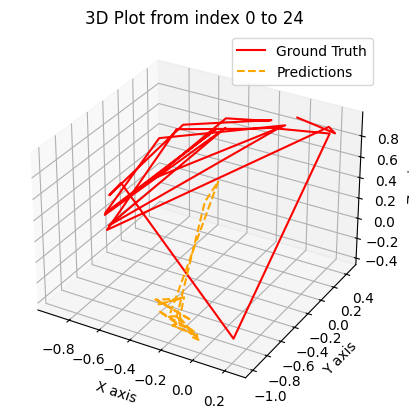

In [29]:
plot_3d_subset(norm_relative_pos.cpu(), norm_predictions.cpu(), start_index=0, subset_size=24)

SyntaxError: incomplete input (2854027421.py, line 1)